In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    cohen_kappa_score,
    balanced_accuracy_score,
    roc_auc_score
)


In [25]:
#Load the cleaned data
merged = pd.read_csv("/Users/inigo/Downloads/cleaned_data (1).csv")

In [26]:
#Available columns
columns = merged.columns.tolist()
print("Columns:", columns)

Columns: ['EmployeeID', 'BenefitID', 'SatisfactionScore', 'Comments', 'UsageFrequency', 'LastUsedDate', 'BenefitType', 'BenefitSubType', 'BenefitCost', 'Gender_Female', 'Gender_Male', 'Gender_Non-Binary', 'Department_Finance', 'Department_HR', 'Department_IT', 'Department_Marketing', 'Department_Sales', 'Age_Gen_Boomer', 'Age_Gen_Gen_X', 'Age_Gen_Gen_Z', 'Age_Gen_Millenial', 'TenureGroups_ >25_years', 'TenureGroups_16-25_years', 'TenureGroups_5-15_years', 'TenureGroups_<5_years', 'BenefitFlag_Cell_Phone_Allowance_Monthly_Communications', 'BenefitFlag_Childcare_After-School_Care', 'BenefitFlag_Childcare_On-Site_Infant_Care', 'BenefitFlag_Commuter_Benefits_Transit_Subsidy', 'BenefitFlag_Flexible_Spending_Account_Healthcare_FSA', 'BenefitFlag_Gym_Membership_Family_Membership', 'BenefitFlag_Gym_Membership_Tier_1_Partners', 'BenefitFlag_Gym_Membership_Tier_2_Partners', 'BenefitFlag_Gym_Membership_Tier_3_Partners', 'BenefitFlag_Health_Insurance_HDHP_Individual', 'BenefitFlag_Health_Insurance

Analyze SatisfactionScore distributions by BenefitID , BenefitSubType,
and demographics.

<Figure size 1400x700 with 0 Axes>

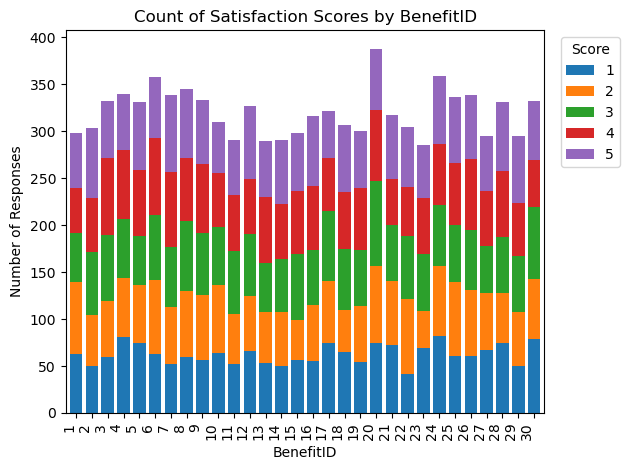

In [27]:
#BenefitID
counts_id = pd.crosstab(
    merged['BenefitID'],
    merged['SatisfactionScore']
).sort_index(axis=1)

# Do the plot
plt.figure(figsize=(14, 7))
counts_id.plot(kind='bar', stacked=True, width=0.8)
plt.title('Count of Satisfaction Scores by BenefitID')
plt.xlabel('BenefitID')
plt.ylabel('Number of Responses')
plt.xticks(rotation=90, ha='right')
plt.legend(title='Score', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

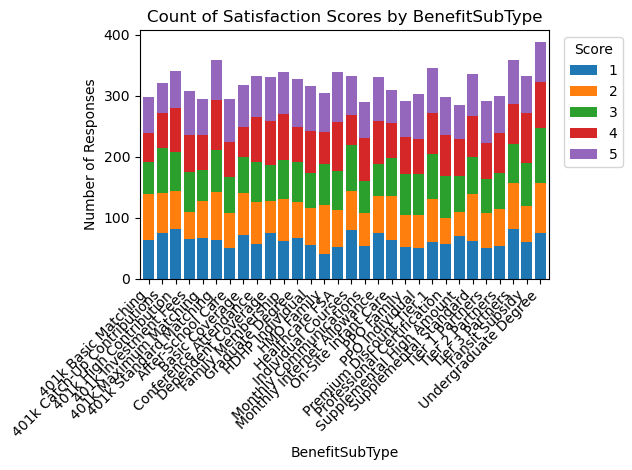

In [28]:
#BenefitSubTypes
counts_sub = pd.crosstab(
    merged['BenefitSubType'],
    merged['SatisfactionScore']
).sort_index(axis=1)

#Plot results
plt.figure(figsize=(12, 6))
counts_sub.plot(kind='bar', stacked=True, width=0.8)
plt.title('Count of Satisfaction Scores by BenefitSubType')
plt.xlabel('BenefitSubType')
plt.ylabel('Number of Responses')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


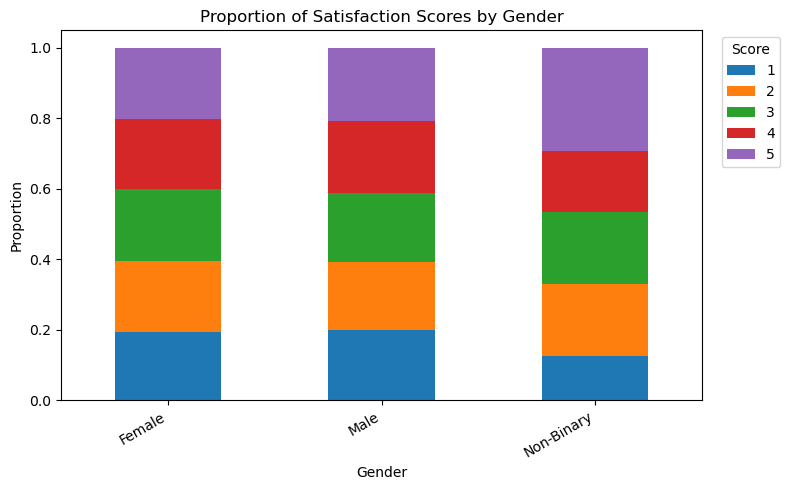

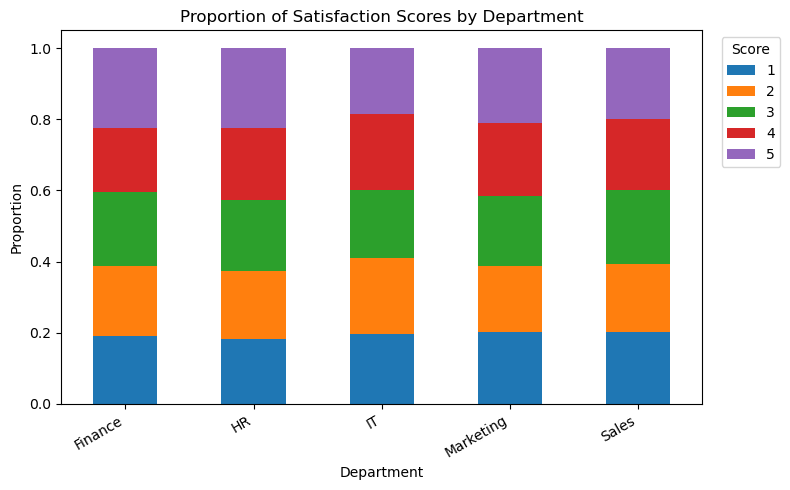

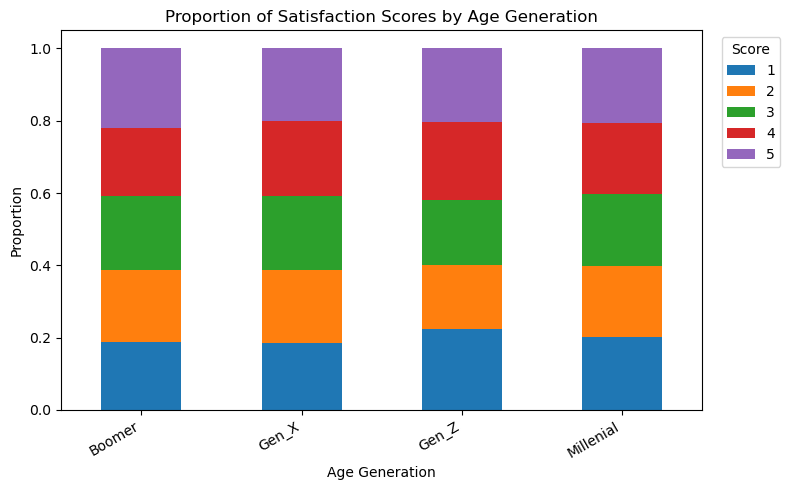

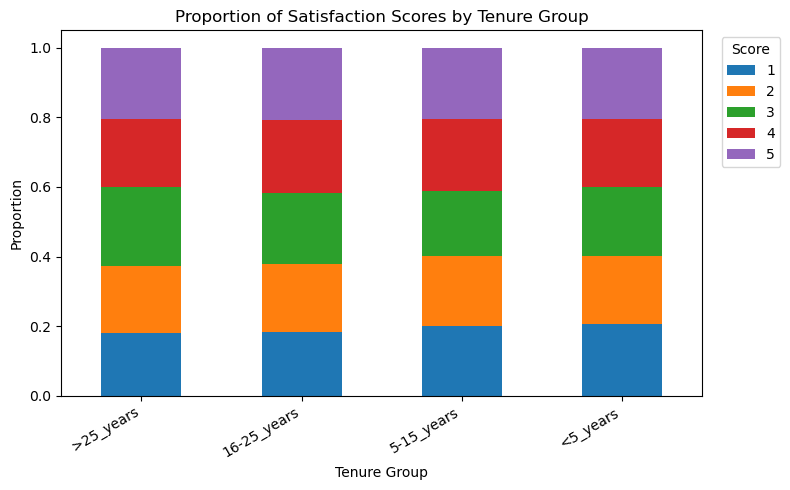

In [29]:
#Select Demograhipc columns to analyze
merged['Gender']     = merged[[c for c in merged if c.startswith('Gender_')]].idxmax(axis=1).str.replace('Gender_', '')
merged['Department'] = merged[[c for c in merged if c.startswith('Department_')]].idxmax(axis=1).str.replace('Department_', '')
merged['AgeGen']     = merged[[c for c in merged if c.startswith('Age_Gen_')]].idxmax(axis=1).str.replace('Age_Gen_', '')
merged['Tenure']     = merged[[c for c in merged if c.startswith('TenureGroups_')]].idxmax(axis=1).str.replace('TenureGroups_', '')

#Function to plot full score distribution
def plot_full(col, title):
    counts = pd.crosstab(merged[col], merged['SatisfactionScore'])
    props  = counts.div(counts.sum(axis=1), axis=0)
    props.plot(kind='bar', stacked=True, figsize=(8,5))
    plt.title(f'Proportion of Satisfaction Scores by {title}')
    plt.xlabel(title)
    plt.ylabel('Proportion')
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Score', bbox_to_anchor=(1.02,1), loc='upper left')
    plt.tight_layout()
    plt.show()

#Generate plots for each demographic
for col, name in [
    ('Gender', 'Gender'),
    ('Department', 'Department'),
    ('AgeGen', 'Age Generation'),
    ('Tenure', 'Tenure Group')
]:
    plot_full(col, name)


Analyze correlation. Since we have two categorical values, we have to use another statistics Cramer's V

In [30]:

#Build contingency table
ct = pd.crosstab(merged['UsageFrequency'], merged['SatisfactionScore'])

#Chi-square test
chi2, p, dof, expected = chi2_contingency(ct)

#Compute Cramér’s V
n = ct.values.sum()
k, r = ct.shape[1], ct.shape[0]
cramers_v = np.sqrt(chi2 / (n * (min(k-1, r-1))))

print(f"Cramér’s V between UsageFrequency and SatisfactionScore: {cramers_v:.3f}")
print(f"  (χ² = {chi2:.2f}, p = {p:.3g}, n = {n})")


Cramér’s V between UsageFrequency and SatisfactionScore: 0.029
  (χ² = 33.34, p = 0.763, n = 9612)


Knowing how often someone uses a benefit tells you virtually nothing about how satisfied they are with it. Usage frequency does not help predict satisfaction scores.

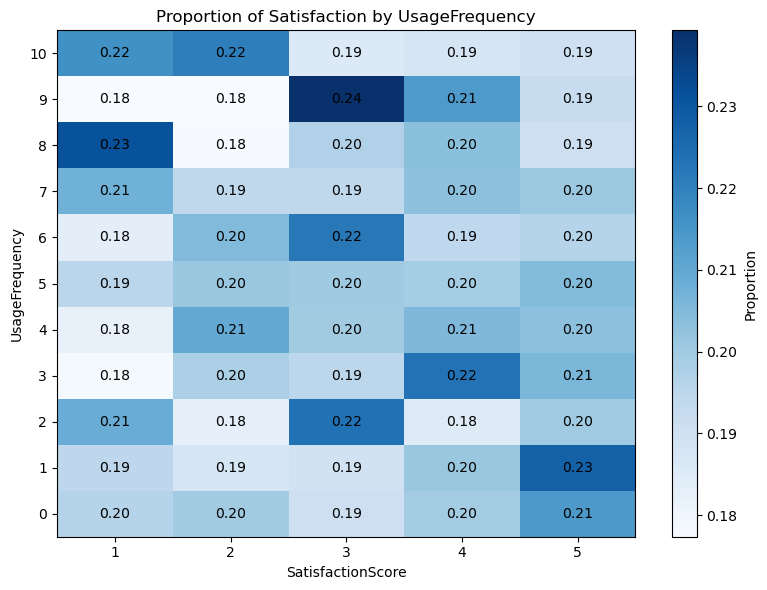

In [31]:
#Build contingency and proportions
ct = pd.crosstab(merged['UsageFrequency'], merged['SatisfactionScore'])
props = ct.div(ct.sum(axis=1), axis=0)

#Plot heatmap
plt.figure(figsize=(8,6))
plt.imshow(props, aspect='auto', cmap='Blues', origin='lower')
plt.colorbar(label='Proportion')
plt.xticks(range(props.shape[1]), props.columns)
plt.yticks(range(props.shape[0]), props.index)
plt.xlabel('SatisfactionScore')
plt.ylabel('UsageFrequency')
plt.title('Proportion of Satisfaction by UsageFrequency')

# nnotate
for i in range(props.shape[0]):
    for j in range(props.shape[1]):
        plt.text(j, i, f"{props.iat[i,j]:.2f}", ha='center',
                 va='center', color='white' if props.iat[i,j]>0.5 else 'black')
plt.tight_layout()
plt.show()


 there is no meaningful relationship between how often someone uses a benefit and how satisfied they are with it.

Sentiment analysis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/inigo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment distribution (% of comments):
Sentiment
positive    44.3
neutral     33.3
negative    22.5
Name: proportion, dtype: float64


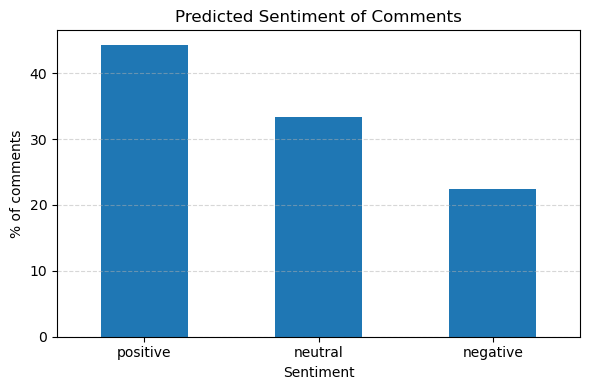

In [32]:
#Download VADER lexicon
nltk.download('vader_lexicon')

#Initialize analyzer
sia = SentimentIntensityAnalyzer()

#Compute compound score and map to labels
def label_sentiment(text):
    score = sia.polarity_scores(str(text))['compound']
    if score >=  0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

merged['Sentiment'] = merged['Comments'].apply(label_sentiment)

#Inspect distribution
counts = merged['Sentiment'].value_counts(normalize=True).mul(100).round(1)
print("Sentiment distribution (% of comments):")
print(counts)

#bar chart
plt.figure(figsize=(6,4))
counts.plot(kind='bar')
plt.ylabel("% of comments")
plt.title("Predicted Sentiment of Comments")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Overall, nearly half of all open-ended comments are positive (≈44%), about a third are neutral (≈33%), and roughly one in four are negative (≈23%). This suggests the general tone is favorable, but a substantial minority voices frustrations. 

Regression on SatisfactionScore

In [33]:
# 1. Prepare X & y
X = merged.drop(columns=['SatisfactionScore', 'Comments', 'LastUsedDate','EmployeeID', 'BenefitID', 'LastUsedDate','Gender','AgeGen','BenefitType','BenefitSubType','Department','Tenure'])
y = merged['SatisfactionScore'].astype(int)

In [34]:
# 1. Create dummies only for 'Sentiment'
sent_dummies = pd.get_dummies(X['Sentiment'], prefix='Sentiment', drop_first=True)

# 2. Concatenate to the DataFrame and drop the original column
X = pd.concat([X.drop(columns=['Sentiment']), sent_dummies], axis=1)

# 3. Now proceed with the train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)


In [35]:
# 3. Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4. Define models
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial', solver='lbfgs', max_iter=1000, class_weight='balanced'
    ),
    'Random Forest'      : RandomForestClassifier(
        n_estimators=200, random_state=42, class_weight='balanced'
    ),
    'Gradient Boosting'  : GradientBoostingClassifier(
        n_estimators=200, random_state=42
    ),
    'SVM (RBF kernel)'   : SVC(
        kernel='rbf', probability=True, random_state=42, class_weight='balanced'
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# 5. Set up 5-fold stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 6. Train, CV and test evaluate each
results = []
for name, model in models.items():
    # choose scaled or unscaled data
    Xtr, Xte = (
        (X_train_scaled, X_test_scaled)
        if name in ['Logistic Regression', 'SVM (RBF kernel)', 'K-Nearest Neighbors']
        else (X_train, X_test)
    )

    # 6.1 Cross‐validation on the TRAINING SET
    cv_scores = cross_val_score(model, Xtr, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    cv_mean, cv_std = cv_scores.mean(), cv_scores.std()

    # 6.2 Fit on full training set and evaluate on the HOLD‐OUT test set
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    test_acc = accuracy_score(y_test, y_pred)

    results.append({
        'Model': name,
        'CV Accuracy (mean ± std)': f"{cv_mean:.3f} ± {cv_std:.3f}",
        'Test Accuracy': f"{test_acc:.3f}"
    })

# 7. Display results
results_df = pd.DataFrame(results).sort_values('Test Accuracy', ascending=False)
print(results_df.to_string(index=False))


              Model CV Accuracy (mean ± std) Test Accuracy
      Random Forest            0.536 ± 0.012         0.543
   SVM (RBF kernel)            0.510 ± 0.005         0.519
  Gradient Boosting            0.500 ± 0.008         0.511
Logistic Regression            0.444 ± 0.004         0.442
K-Nearest Neighbors            0.411 ± 0.017         0.432


In [36]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.39      0.51      0.44       376
           2       0.47      0.52      0.49       378
           3       0.36      0.35      0.35       385
           4       0.42      0.37      0.39       387
           5       0.55      0.43      0.48       397

    accuracy                           0.43      1923
   macro avg       0.44      0.43      0.43      1923
weighted avg       0.44      0.43      0.43      1923

[[190  58  55  57  16]
 [ 94 197  54  18  15]
 [ 84  88 133  38  42]
 [ 82  25  70 142  68]
 [ 34  54  60  80 169]]


Recategorize the classes

In [ ]:
# 1. Prepare feature matrix X by dropping identifiers, raw text/date, and parent categories
X = merged.drop(columns=[
    'SatisfactionScore', 'Comments', 'LastUsedDate',
    'EmployeeID', 'BenefitID',
    'Gender', 'AgeGen',
    'BenefitType', 'BenefitSubType',
    'Department', 'Tenure'
])

# 2. Create a 3-level target y: scores 1–2→1 (Low), 3→2 (Medium), 4–5→3 (High)
y_orig = merged['SatisfactionScore'].astype(int)
y = y_orig.copy()
y[y_orig <= 2] = 1
y[y_orig == 3] = 2
y[y_orig >= 4] = 3

# 3. One-hot encode any remaining categorical columns
object_columns = X.select_dtypes(include=['object']).columns.tolist()
X = pd.get_dummies(X, columns=object_columns, drop_first=True)

# 4. Split into train and test sets, stratifying on y
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

# 5. Scale features for models that require scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(float))
X_test_scaled  = scaler.transform(X_test.astype(float))

# 6. Define your models, using balanced class weights where supported
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial', solver='lbfgs',
        max_iter=1000, class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, random_state=42,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, random_state=42
    ),
    'SVM (RBF kernel)': SVC(
        kernel='rbf', probability=True,
        random_state=42, class_weight='balanced'
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

# 7. Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 8. Train, cross-validate, and evaluate each model
results = []
for name, model in models.items():
    # Choose scaled data for certain models, raw for others
    X_tr, X_te = (
        (X_train_scaled, X_test_scaled)
        if name in ['Logistic Regression', 'SVM (RBF kernel)', 'K-Nearest Neighbors']
        else (X_train, X_test)
    )

    # 8.1 Cross-validation on the training set
    cv_scores = cross_val_score(
        model, X_tr, y_train, cv=cv,
        scoring='accuracy', n_jobs=-1
    )
    cv_mean, cv_std = cv_scores.mean(), cv_scores.std()

    # 8.2 Fit on full training set and evaluate on hold-out test set
    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    test_acc = accuracy_score(y_test, y_pred)

    # Record results
    results.append({
        'Model': name,
        'CV Accuracy (mean ± std)': f"{cv_mean:.3f} ± {cv_std:.3f}",
        'Test Accuracy': f"{test_acc:.3f}"
    })

    # Optional: print detailed classification report
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, target_names=['Low','Medium','High']))

# 9. Display summary table of performance
results_df = pd.DataFrame(results).sort_values('Test Accuracy', ascending=False)
print("\nSummary:\n", results_df.to_string(index=False))



=== Logistic Regression ===
              precision    recall  f1-score   support

         Low       0.62      0.56      0.59       755
      Medium       0.26      0.31      0.29       384
        High       0.77      0.78      0.78       784

    accuracy                           0.60      1923
   macro avg       0.55      0.55      0.55      1923
weighted avg       0.61      0.60      0.60      1923


=== Random Forest ===
              precision    recall  f1-score   support

         Low       0.73      0.75      0.74       755
      Medium       0.43      0.41      0.42       384
        High       0.77      0.78      0.78       784

    accuracy                           0.69      1923
   macro avg       0.65      0.65      0.65      1923
weighted avg       0.69      0.69      0.69      1923


=== Gradient Boosting ===
              precision    recall  f1-score   support

         Low       0.65      0.86      0.74       755
      Medium       0.43      0.14      0.22       

In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    cohen_kappa_score,
    balanced_accuracy_score
)

best_rf = models['Random Forest']
best_rf.fit(X_train, y_train)
X_te = X_test

# Predict
y_pred = best_rf.predict(X_te)

# 1. Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1,2,3])
print("Confusion Matrix (rows=true, cols=predicted):\n", cm)

# 2. Precision, recall, F1, support
prec, rec, f1, sup = precision_recall_fscore_support(
    y_test, y_pred, labels=[1,2,3], zero_division=0
)
print("\nClass | Precision | Recall | F1-score | Support")
for cls, p, r, f, s in zip(['Low','Medium','High'], prec, rec, f1, sup):
    print(f"  {cls:<6} |   {p:.2f}     |  {r:.2f}   |   {f:.2f}   |   {s}")

# 3. Cohen’s Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"\nCohen’s Kappa: {kappa:.3f}")

# 4. Balanced accuracy
bal_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {bal_acc:.3f}")


Confusion Matrix (rows=true, cols=predicted):
 [[569 119  67]
 [118 156 110]
 [ 89  87 608]]

Class | Precision | Recall | F1-score | Support
  Low    |   0.73     |  0.75   |   0.74   |   755
  Medium |   0.43     |  0.41   |   0.42   |   384
  High   |   0.77     |  0.78   |   0.78   |   784

Cohen’s Kappa: 0.519
Balanced Accuracy: 0.645
